In [3]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
from src.functions.basic_functions import coordinates_change
from src.functions.calibration import capacity_estimation
from src.functions.grid import land_reference_subunit,construct_grid, estimate_kernel_density_database
from src.functions.weights import weigths_continent, weighted_plants_dataset
from src.functions.plots import unweighted_plot_density, choose_bandwidth,weighted_plants_plot_density,weighted_plot_density, plot_density_combination, unweighted_plot_density_general


In [16]:
from src.functions.calibration import distance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
import global_land_mask,tqdm, itertools
from global_land_mask import globe
import sklearn
sklearn.set_config(enable_metadata_routing=True)
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import pycountry
from joblib import Parallel,delayed


In [3]:
path="C:\\Users\\Denisa.draghia\\Desktop\\Acier\\"
df_gspt=pd.read_csv(path+"data\\clean_data\\steel_factories_dataset_reg.csv")

Cross-Validation Bandwiths

In [ ]:
choose_bandwidth('Europe','exponential') # 0.041363636363636366
choose_bandwidth('Europe','gaussian') #0.08172727272727273

In [6]:
choose_bandwidth('world','exponential') 

0.13218181818181818

Maps

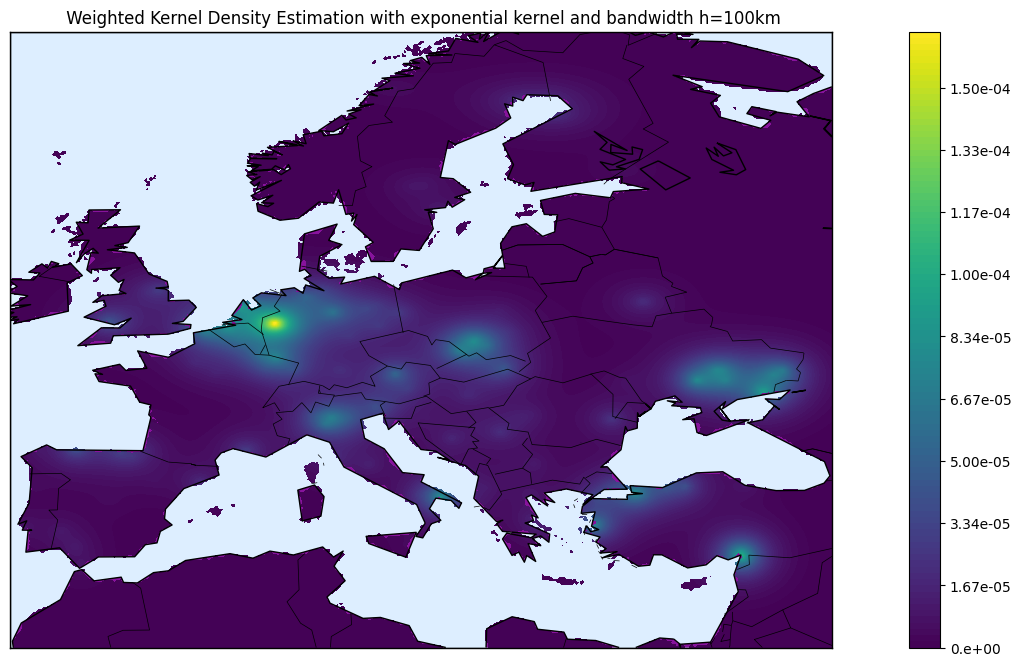

In [4]:

b=weighted_plants_plot_density('Europe', 'exponential', 0.014)


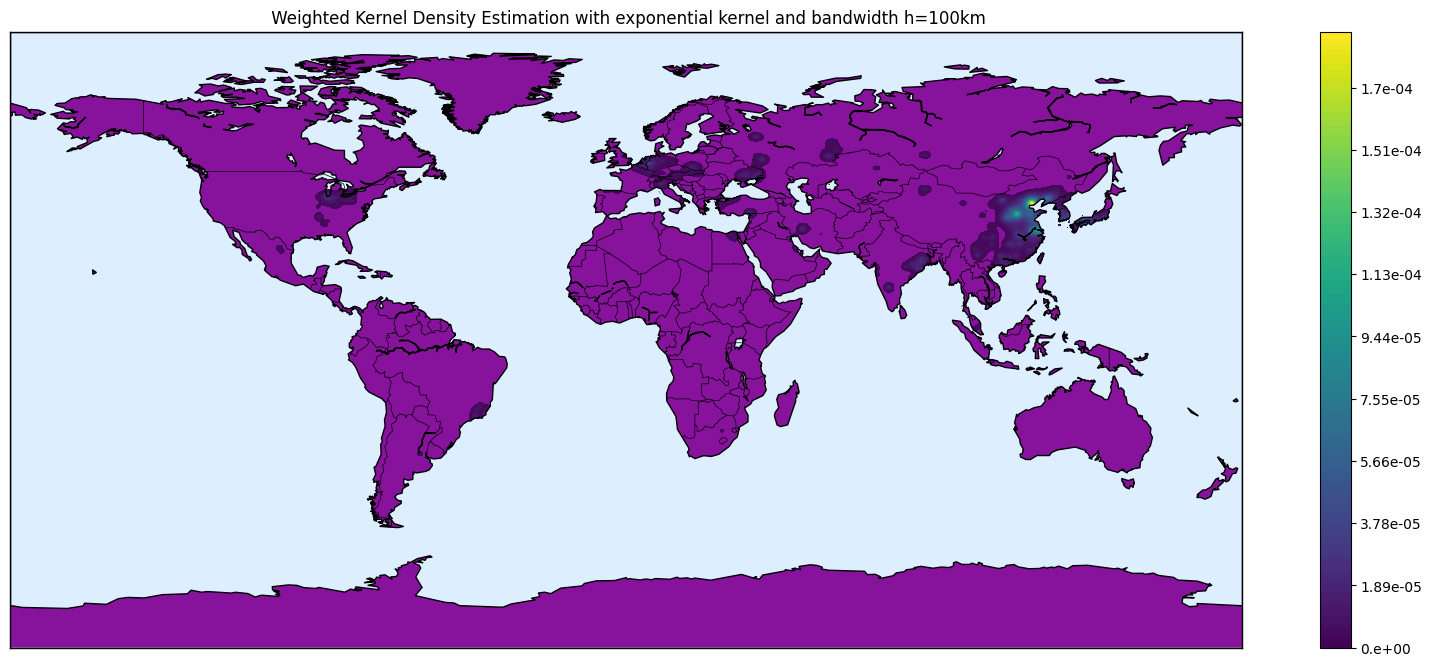

In [4]:
weighted_plants_plot_density('world','exponential',0.015)

In [ ]:
unweighted_plot_density('Asia', 'exponential', 0.014)

In [ ]:
weighted_plants_plot_density('Europe', 'exponential', 0.014)

In [6]:
weighted_plants_plot_density('world','exponential',0.015)

Mix LitPop & Kernel Maps

In [4]:
world=pd.read_csv(path+"data\intermediary_data\densities\world_all_densities.csv")

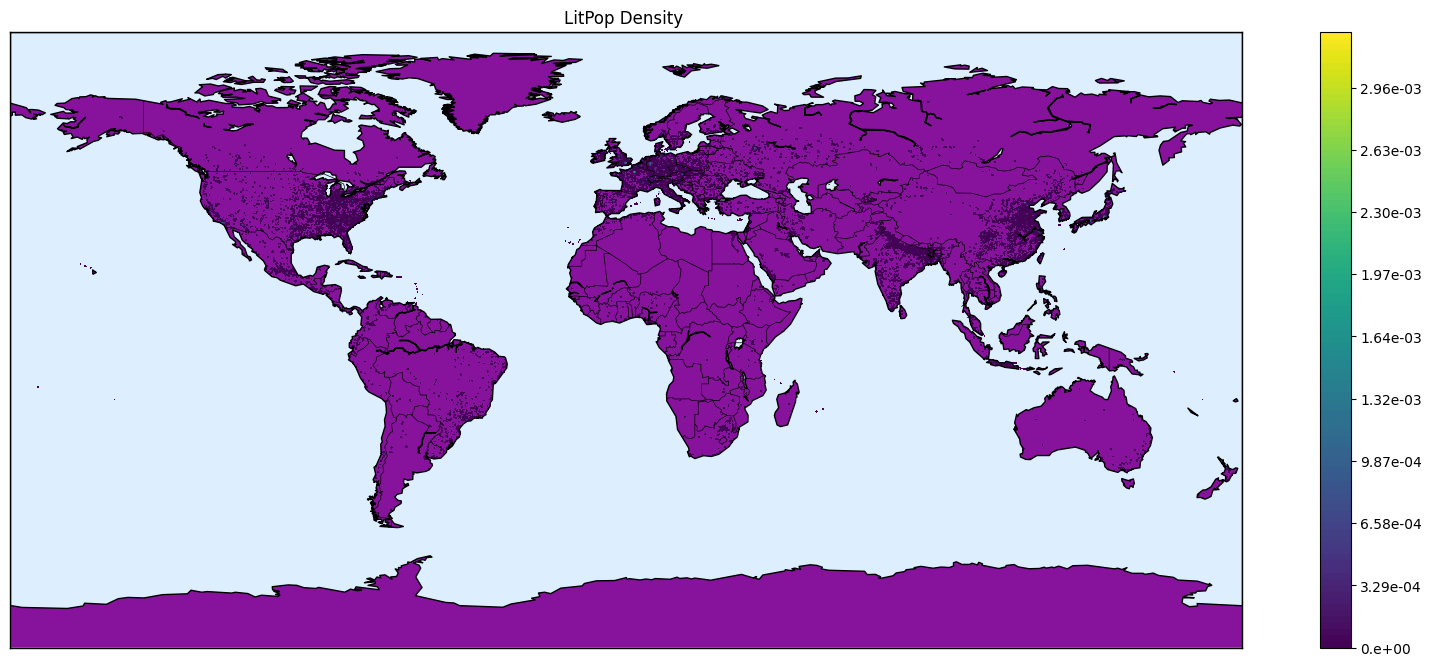

In [5]:
plot_density_combination(world,1)

Check capacity 

In [7]:
steel_capacity=df_gspt['Nominal crude steel capacity (ttpa)']
total_cap=steel_capacity.sum()

list_cont=['Europe','Africa','Central & South America','North America','Australia','Asia']
capacity_continent={}
for cont in list_cont:
    steel_capacity=df_gspt.loc[df_gspt["Region"]==cont]['Nominal crude steel capacity (ttpa)']
    capacity_continent[cont]=steel_capacity.sum()/total_cap
capacity_continent['South America']=capacity_continent['Central & South America']
del capacity_continent['Central & South America']

In [ ]:
d=capacity_estimation(0.015,'exponential')

LitPop Database

In [ ]:
result_exp_50_bayes = world.groupby('continent')['a_posteriori_distribution_50'].sum()
result_exp_50_bayes

In [7]:
work=world.copy()
work=work[['latitude','longitude','a_posteriori_distribution','kernel_density']]
work=work.rename(columns={'a_posteriori_distribution':'value'})
work

,latitude,longitude,value,kernel_density
0,12.541667,-70.041667,5.228392e-09,1.598639e-14
1,12.541667,-69.958333,8.610449e-10,1.903487e-14
2,38.458333,70.958333,4.217421e-10,1.204148e-08
3,38.375000,70.708333,8.609688e-10,1.317406e-08
4,38.375000,70.791667,7.493842e-10,1.211931e-08
...,...,...,...,...
2203390,-22.291667,31.125000,3.718317e-12,1.914494e-10
2203391,-22.291667,31.208333,4.485553e-12,1.770339e-10
2203392,-22.291667,31.291667,4.761885e-12,1.632477e-10
2203393,-22.291667,31.375000,4.249344e-12,1.501248e-10


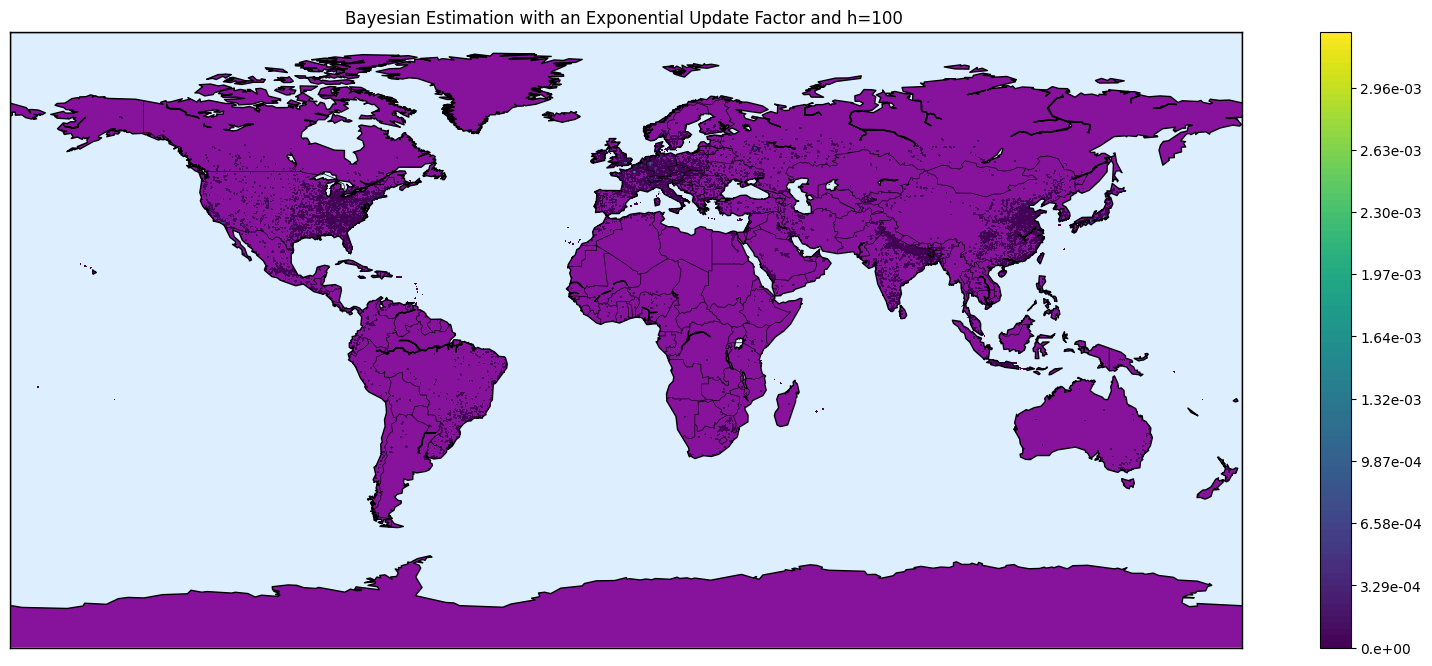

In [31]:
plot_density_combination(work,1)

In [6]:
dens=pd.read_csv('data\\intermediary_data\\densities\\all_densities.csv')
world=pd.read_csv("data\intermediary_data\densities\world_density.csv")

In [ ]:
world

In [ ]:
update_50_exp=np.load("bayes_exp_50.npy")
world['bayesian_update_50']=pd.DataFrame(update_50_exp)
world['numerator_50']=np.where(world['value'] == 0, 0, np.exp(np.log(world['value']) + world['bayesian_update_50'] ))
integral=world['numerator_50'].sum()
world['a_posteriori_distribution_50']=world['numerator_50']/integral
work=world.copy()

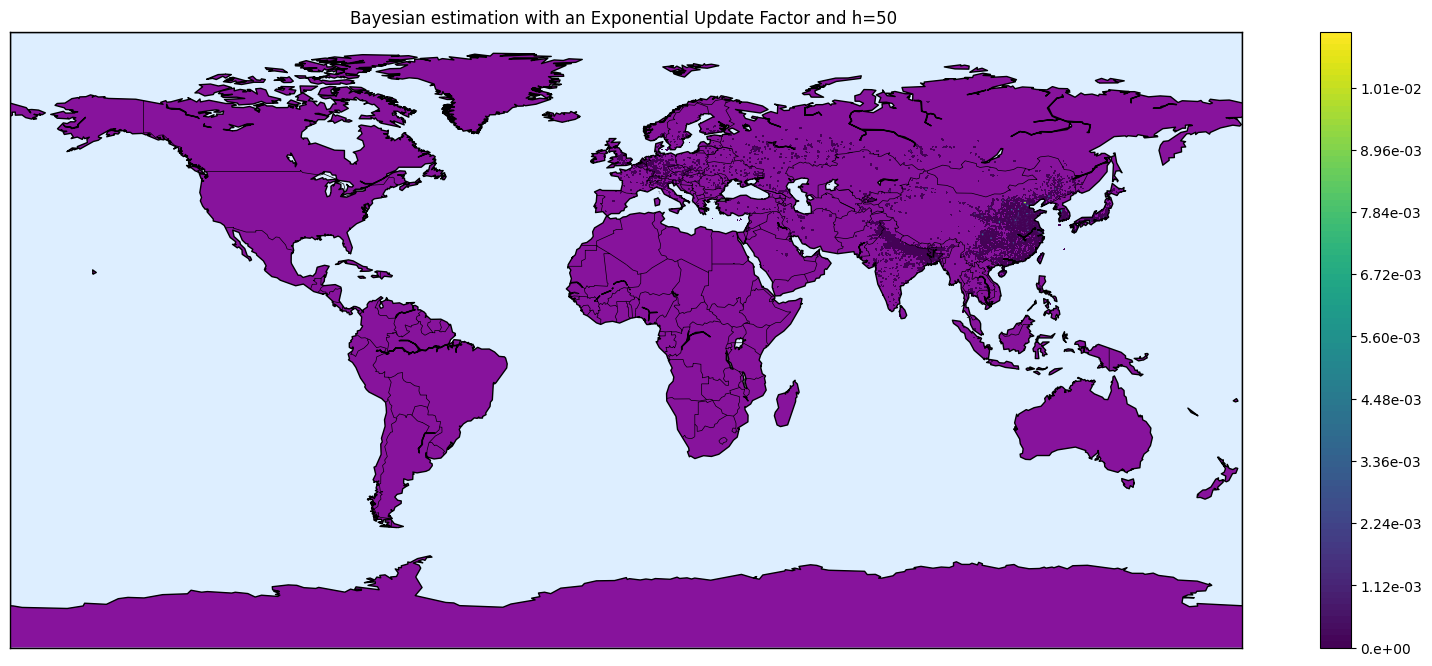

In [7]:
work=work.drop(columns={"value"})
work=work.rename(columns={'a_posteriori_distribution_50':"value",'bayesian_update_50':'kernel_density'})
work
plot_density_combination(work,1)

In [8]:
capacity_estimation_continent = pd.DataFrame.from_dict(capacity_continent, orient="index")
capacity_estimation_continent = capacity_estimation_continent.rename(columns={0 : "true_cap"})
capacity_estimation_continent["exp_kernel_50km_cap"] = dens.groupby('continent')['exp_kernel_50'].sum()
capacity_estimation_continent["gaussian_kernel_50km_cap"]= dens.groupby('continent')['gaussian_kernel_50'].sum()
capacity_estimation_continent["exp_kernel_100km_cap"] = dens.groupby('continent')['exp_kernel_100'].sum()
capacity_estimation_continent["litpop"]=dens.groupby('continent')['value'].sum()
capacity_estimation_continent

,true_cap,exp_kernel_50km_cap,gaussian_kernel_50km_cap,exp_kernel_100km_cap,litpop
Europe,0.135485,0.143836,0.145080,0.139179,0.193642
Africa,0.017734,0.025559,0.024620,0.028790,0.059334
North America,0.068107,0.062518,0.061344,0.065059,0.273928
Australia,0.002875,0.005496,0.005351,0.006131,0.024988
Asia,0.748907,0.751692,0.752957,0.749435,0.415623
South America,0.026892,0.007576,0.007349,0.008103,0.028479


In [18]:
df=pd.DataFrame()
df['absolute_percentage_error_exp_50'] = capacity_estimation_continent['exp_kernel_50km_cap']/capacity_estimation_continent['true_cap'] -1
df['absolute_percentage_error_exp_100'] = capacity_estimation_continent['exp_kernel_100km_cap']/capacity_estimation_continent['true_cap'] -1
df['absolute_percentage_error_gaussian_50']=capacity_estimation_continent['gaussian_kernel_50km_cap']/capacity_estimation_continent['true_cap'] -1
df

,absolute_percentage_error_exp_50,absolute_percentage_error_exp_100,absolute_percentage_error_gaussian_50
Europe,0.061643,0.027271,0.070826
Africa,0.441220,0.623455,0.388286
North America,-0.082057,-0.044752,-0.099299
Australia,0.911869,1.132532,0.861484
Asia,0.003718,0.000705,0.005407
South America,-0.718276,-0.698675,-0.726726


In [38]:
# correlation
kernel_corr_50=dens['exp_kernel_50'].corr(dens['gaussian_kernel_50']) #0.9779846369382176
kernel_corr_exp=dens['exp_kernel_50'].corr(dens['exp_kernel_100']) # 0.8966759520346144